In [29]:
import os
import time
import random
import numpy as np

from scipy.stats import ortho_group


import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential
from torch import Tensor

torch.set_default_dtype(torch.float64)

from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    Size,
    SparseTensor,
    torch_sparse,
)

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse, to_undirected
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, knn_graph
from torch_geometric.datasets import QM9
from torch_scatter import scatter
from torch_cluster import knn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import uproot
import vector
vector.register_awkward()
import awkward as ak

from IPython.display import HTML

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 2.0.1
PyG version 2.3.1


## Let's make the graph dataset from pointcloud dataset

In [30]:
eta, phi = torch.randn([5, 1]), torch.randn([5, 1])

In [31]:
pos = torch.cat([eta, phi], dim=-1)
pos.shape

torch.Size([5, 2])

In [32]:
edge_index = torch_geometric.nn.knn_graph(x = pos, k = 2)
edge_index = to_undirected(edge_index, num_nodes=pos.shape[0])

In [33]:
edge_index

tensor([[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 4, 4],
        [1, 4, 0, 4, 3, 4, 2, 4, 0, 1, 2, 3]])

# Let's create a jet-graph dataset 

In [34]:
class Jet_Dataset(data.Dataset):

    def __init__(self, dataset_path:str, tree_name:str = 'tree', k:int = 5) -> None:
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        
        
        self.dataset = uproot.open(dataset_path)
        self.tree = self.dataset[tree_name].arrays()
        
        self.num_entries = self.dataset[tree_name].num_entries
        
        self.part_feat = self.dataset[tree_name].keys(filter_name='part_*')
        self.jet_feat = self.dataset[tree_name].keys(filter_name='jet_*')
        self.labels = self.dataset[tree_name].keys(filter_name='labels_*')
        
        self.k = k
        
        
        #self.pc_dataset = [ self.transform_jet_to_point_cloud(idx) for idx in range(self.num_entries-1) ]
        

    def transform_jet_to_point_cloud(self, idx:int) -> Data :
    
        npart = self.tree['jet_nparticles'].to_numpy()[idx:idx+1]
        
        part_feat_list = [ak.flatten(self.tree[part_feat][idx:idx+1]).to_numpy() for part_feat in self.part_feat]
        
        jet_pt = self.tree['jet_pt'].to_numpy()[idx:idx+1]
        jet_eta = self.tree['jet_eta'].to_numpy()[idx:idx+1]
        jet_phi = self.tree['jet_phi'].to_numpy()[idx:idx+1]
        jet_energy = self.tree['jet_energy'].to_numpy()[idx:idx+1]
        jet_tau21 = self.tree['jet_tau2'].to_numpy()[idx:idx+1]/self.tree['jet_tau1'].to_numpy()[idx:idx+1]
        jet_tau32 = self.tree['jet_tau3'].to_numpy()[idx:idx+1]/self.tree['jet_tau2'].to_numpy()[idx:idx+1]
        jet_tau43 = self.tree['jet_tau4'].to_numpy()[idx:idx+1]/self.tree['jet_tau3'].to_numpy()[idx:idx+1]
        
        
        jet_sd_mass = self.tree['jet_sdmass'].to_numpy()[idx:idx+1]
        
        jet_feat = np.stack([jet_pt, jet_eta, jet_phi, jet_energy, jet_tau21, jet_tau32, jet_tau43]).T
              
        jet_feat = np.repeat(jet_feat, int(npart), axis=0)
             
        part_feat = np.stack(part_feat_list).T
        
        total_jet_feat = np.concatenate((part_feat, jet_feat), axis=-1)
        total_jet_feat[np.isnan(total_jet_feat)] = 0.
        
        #print(type(total_jet_feat), 'total_jet_feat shape : ', total_jet_feat.shape)
        
        jet_class = -1
        
        if(self.tree['label_QCD'].to_numpy()[idx:idx+1] == 1) : jet_class = 0
        
        if( (self.tree['label_Tbqq'].to_numpy()[idx:idx+1] == 1) or
            (self.tree['label_Tbl'].to_numpy()[idx:idx+1] == 1)) : jet_class = 2
        
        if( (self.tree['label_Zqq'].to_numpy()[idx:idx+1] == 1) or
            (self.tree['label_Wqq'].to_numpy()[idx:idx+1] == 1)) : jet_class = 0
        
        if( (self.tree['label_Hbb'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_Hcc'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_Hgg'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_H4q'].to_numpy()[idx:idx+1] == True) or
            (self.tree['label_Hqql'].to_numpy()[idx:idx+1] == True) ) : jet_class = 1
        
        part_eta = torch.tensor( ak.flatten(self.tree['part_deta'][idx:idx+1]).to_numpy() )
        part_phi = torch.tensor( ak.flatten(self.tree['part_dphi'][idx:idx+1]).to_numpy() )
        eta_phi_pos = torch.stack([part_eta, part_phi], dim=-1)
        
        edge_index = torch_geometric.nn.pool.knn_graph(x = eta_phi_pos, k = self.k)
        
        src, dst = edge_index
                
        part_del_eta = part_eta[dst] - part_eta[src]
        part_del_phi = part_phi[dst] - part_phi[src]
        
        part_del_R = torch.hypot(part_del_eta, part_del_phi).view(-1, 1) # -- why do we need this view function ? 
        
        data = Data(x=torch.tensor(total_jet_feat), edge_index=edge_index, edge_deltaR = part_del_R)
        data.label = torch.tensor([jet_class])
        data.sd_mass = torch.tensor(jet_sd_mass)
        data.seq_length = torch.tensor(npart)
        
        return data    
        

    def __len__(self) -> int:
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.num_entries#len(self.pc_dataset)
    
    def __getitem__(self, idx:int) -> Data :
        # Return the idx-th data point of the dataset
    
        return self.transform_jet_to_point_cloud(idx)#self.pc_dataset[idx]#data_point, data_label


In [35]:
dataset_path = '/Users/sanmay/Documents/ICTS_SCHOOL/Main_School/JetDataset/'
file_name = dataset_path + 'JetClass_example_100k.root' # -- from -- "https://hqu.web.cern.ch/datasets/JetClass/example/" #
jet_dataset = Jet_Dataset(dataset_path=file_name)

In [36]:
data_loader = DataLoader(dataset=jet_dataset, batch_size=1, shuffle = True)

In [37]:
bg = next(iter(data_loader))

In [38]:
bg.edge_index

tensor([[ 9, 24,  1,  5,  2, 24, 38,  9,  0,  5,  5, 27, 33, 35, 22,  8, 40, 23,
         16, 26, 11,  7, 17, 36, 25,  2, 35, 33, 27,  0, 20, 23, 10, 40, 16,  4,
         30, 11, 17, 36,  3, 40, 28, 16, 26,  0, 24,  1,  5, 38, 23,  6, 16, 26,
         20,  4, 17, 25, 36,  7, 36, 17, 25, 37, 11, 11, 25,  4, 17,  7, 37, 12,
         36, 17, 25, 26, 34, 16, 18, 29, 26, 10, 23, 15, 20, 36, 11, 25,  4, 12,
         29, 27, 15,  2,  5, 35, 33, 22,  5,  1,  6, 23, 40, 10, 16, 22, 33, 27,
          2, 35, 33, 21, 35,  2,  5, 20, 10,  6, 16, 40,  9,  1,  0, 38,  5, 17,
         11, 36,  4, 13, 16, 10, 15, 23, 20,  2,  5, 33, 22, 29,  8,  3, 32, 40,
         16, 18, 27,  2,  5,  0,  7,  4, 11, 17, 13, 19, 38, 35,  1, 22, 40,  3,
         20,  8, 23, 22, 35,  2,  5, 27, 21, 15, 22, 27, 33,  5, 33, 19, 22,  2,
         17, 11, 12,  4, 25, 14, 12, 36, 17, 25,  1, 24,  9,  0, 19, 30, 28,  7,
         13,  4, 23, 20,  3,  8,  6, 13, 39, 25, 11,  4],
        [ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2

In [39]:
bg.ptr

tensor([ 0, 42])

In [40]:
torch.where(bg.batch == 2)[0].shape

torch.Size([0])

## The flavors of message passing layer
As a gentle introduction to PyTorch Geometric, we will introduce the first steps of developing a GNN in the **Message Passing** flavor.

<!-- ![](https://drive.google.com/uc?id=1Wdgdq606XW1MelvcU1nW5CxWe1rHsWt1) -->
<img src="https://github.com/chaitjo/dump/raw/main/gnn-layers.png">

## What is a Graph Convolution??

$$H^{(l+1)} = \sigma\left(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W^{(l)}\right)$$

$W^{(l)}$ is the weight parameters with which we transform the input features into messages ($H^{(l)}W^{(l)}$). To the adjacency matrix $A$ we add the identity matrix so that each node sends its own message also to itself: $\hat{A}=A+I$. Finally, to take the average instead of summing, we calculate the matrix $\hat{D}$ which is a diagonal matrix with $D_{ii}$ denoting the number of neighbors node $i$ has. $\sigma$ represents an arbitrary activation function, and not necessarily the sigmoid (usually a ReLU-based activation function is used in GNNs). 

GCN in traditional PyTorch way

In [13]:
class GCNLayer(nn.Module):
    
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, x : Tensor, edge_index : Adj):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections. 
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        data = Data(x=x, edge_index=edge_index)
        
        G = to_networkx(data)
        adjacency_matrix = nx.to_numpy_array(G, nodelist=G.nodes() )
        
        node_feats = x
        adj_matrix = torch.tensor(adjacency_matrix)
        
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

### Test the forward pass of this GCN-Layer from the batched-graph above

GCN in PyG way

In [14]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j


## Formalism

A significant chunk of the code is taken from : https://github.com/chaitjo/geometric-gnn-dojo/blob/main/geometric_gnn_101.ipynb

Firstly, let us formalise our molecular property prediction pipeline. (Our notation will mostly follow what has been introduced in the lectures, but we do make some different choices for variable names.)

### Graph 
Consider a molecular graph $\mathcal{G} = \left( \mathcal{V}, \mathcal{E} \right)$, where $\mathcal{V}$ is a set of $n$ nodes, and $\mathcal{E}$ is a set of edges associated with the nodes. For each node $i \in \mathcal{V}$, we are given a $d_n$-dimensional initial feature vector $h_i \in \mathbb{R}^{d_n}$.
For each edge $(i, j) \in \mathcal{E}$, we are given a $d_e$-dimensional initial feature vector $e_{ij} \in \mathbb{R}^{d_e}$. For Jet graphs, $d_n = 23, d_e = 1$.

### Label/target 
Associated with each graph $\mathcal{G}$ is a scalar target or label $y \in \mathbb{R}^{1}$, which we would like to predict. 

We will design a Message Passing Neural Network for graph property prediction to do this. Our MPNN will consist of several layers of message passing, followed by a global pooling and prediction head.

### MPNN Layer 
The Message Passing operation iteratively updates node features $h_i^{\ell} \in \mathbb{R}^d$ from layer $\ell$ to layer $\ell+1$ via the following equation:
$$
h_i^{\ell+1} = \phi \Bigg( h_i^{\ell}, \oplus_{j \in \mathcal{N}_i} \Big( \psi \left( h_i^{\ell}, h_j^{\ell}, e_{ij} \right) \Big) \Bigg),
$$
where $\psi, \phi$ are Multi-Layer Perceptrons (MLPs), and $\oplus$ is a permutation-invariant local neighborhood aggregation function such as summation, maximization, or averaging.

Let us break down the MPNN layer into three pedagogical steps:
- **Step (1): Message.** For each pair of linked nodes $i, j$, the network first computes a message $m_{ij} =  \psi \left( h_i^{\ell}, h_j^{\ell}, e_{ij} \right)$. The MLP $\psi: \mathbb{R}^{2d + d_e} → \mathbb{R}^d$ takes as input the concatenation of the feature vectors from the source node, destination node, and edge.
    - Note that for the first layer $\ell=0$, $h_i^{\ell=0} = W_{in} \left( h_i \right)$, where $W_{in} \in \mathbb{R}^{d_n}  \rightarrow \mathbb{R}^{d}$ is a simple linear projection (`torch.nn.Linear`) for the initial node features to hidden dimension $d$.
- **Step (2): Aggregate.** At each node $i$, the incoming messages from all its neighbors are then aggregated as $m_{i} = \oplus_{{j \in \mathcal{N}_i}} \left( m_{ij} \right)$, where $\oplus$ is a permutation-invariant function. We will use summation, i.e. $\oplus_{{j \in \mathcal{N}_i}} = \sum_{{j \in \mathcal{N}_i}}$.
- **Step (3): Update.** Finally, the network updates the node feature vector $h_i^{\ell+1} = \phi \left( h_i^{\ell}, m_i \right)$, by concatenating the aggregated message $m_i$ and the previous node feature vector $h_i^{\ell}$, and passing them through an MLP $\phi: \mathbb{R}^{2d} → \mathbb{R}^{d}$.

### Global Pooling and Prediction Head
After $L$ layers of message passing, we obtain the final node features $h_i^{\ell=L}$. As we have a single target $y$ per graph, we must pool all node features into a single graph feature or graph embedding $h_G \in \mathbb{R}^d$ via another permutation-invariant function $R$, sometimes called the 'readout' function, as follows:
$$
h_G = R_{i \in \mathcal{V}} \left( h_i^{\ell=L} \right). 
$$ 
We will use global average pooling over all node features, i.e.
$$
h_G = \frac{1}{|\mathcal{V}|} \sum_{i \in \mathcal{V}} h_i^{\ell=L}. 
$$

The graph embedding $h_G$ is passed through a linear prediction head $W_{pred} \in \mathbb{R}^{d} \rightarrow \mathbb{R}^1$ to obtain the overall prediction $\hat y \in \mathbb{R}^1$:
$$
\hat y = W_{pred} \left( h_G \right).
$$ 

### Loss Function
Our MPNN graph property prediction model can be trained end-to-end via minimizing the standard mean-squared error loss for regression:
$$
\mathcal{L}_{MSE} = \lVert y - \hat y \rVert^2_2.
$$

## Coding the basic Message Passing Neural Network Layer

We will code up the **MPNN Layer** first. 

To do so, we will inherit from the `MessagePassing` base class, which automatically takes care of message propagation and is extremely useful to develop advanced GNN models. To implement a custom MPNN, the user only needs to define the behaviour of the `message` (i.e. $\psi$), the `aggregate`(i.e. $\oplus$), and `update` (i.e. $\phi$) functions. You may also refer to the [PyG documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) for implementing custom message passing layers.

Below, we provide the implementation of a standard MPNN layer as an example, with extensive inline comments to help you figure out what is going on.

In [15]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super(MPNNLayer, self).__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim
        
        #self.node_dim = -1
        

        # MLP `\psi` for computing messages `m_ij`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        
        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the 
        message passing procedure: `message()` -> `aggregate()` -> `update()`.
        
        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`, 
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index=edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j 
        to destination nodes i for each edge (i, j) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take 
        any arguments that were initially passed to `propagate`. Additionally, 
        we can differentiate destination nodes and source nodes by appending 
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`. 
        
        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            edge_attr: (e, d_e) - edge features
        
        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)
    
    def aggregate(self, inputs, index):
        """Step (2) Aggregate

        The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        
        out = scatter(inputs, index, dim=0, reduce=self.aggr)
       
        return out#scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
    
    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the 
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`, 
        as well as any optional arguments that were initially passed to 
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

We have defined a **Message Passing layer** following the equation we had introduced previously. Let us use this layer to code up the full **MPNN graph property prediction model**. This model will take as input molecular graphs, process them via multiple MPNN layers, and predict a single property for each of them.

In [16]:
class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super(MPNNModel, self).__init__()
        
        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)
        
        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))
        
        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns: 
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)
        
        for conv in self.convs:
            h = h + conv(h = h, edge_index = data.edge_index, edge_attr = data.edge_deltaR) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

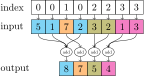

In [28]:
from IPython.core.display import SVG
SVG(filename='scatter_add.svg')

In [17]:
data_loader = DataLoader(dataset=jet_dataset, batch_size=3, shuffle = True)
b_gr = next(iter(data_loader))

In [18]:
b_gr

DataBatch(x=[121, 23], edge_index=[2, 605], edge_deltaR=[605, 1], label=[3], sd_mass=[3], seq_length=[3], batch=[121], ptr=[4])

In [19]:
b_gr.num_nodes, b_gr.num_edges, b_gr.edge_index, b_gr.ptr

(121,
 605,
 tensor([[ 45,   6,   3,  ..., 111, 117, 103],
         [  0,   0,   0,  ..., 120, 120, 120]]),
 tensor([  0,  55,  87, 121]))

In [20]:
layer = MPNNLayer(emb_dim=23, edge_dim=1)
out1 = layer(h=b_gr.x, edge_index=b_gr.edge_index, edge_attr=b_gr.edge_deltaR)

In [21]:
mpnn_model = MPNNModel(num_layers=4, emb_dim=64, in_dim=23, edge_dim=1, out_dim=1)

In [22]:
out = mpnn_model(b_gr)

In [23]:
out

tensor([131.3098, 100.1276, 234.1671], grad_fn=<ViewBackward0>)

## Unit tests for Permutation Invariance and Equivariance

The lectures have repeatedly indicated on certain fundamental properties for machine learning on graphs:
- A **GNN <ins>layer**</ins> is **equivariant** to permutations of the set of nodes in the graph; i.e. as we permute the nodes, the node features produced by the GNN must permute accordingly.
- A **GNN <ins>model**</ins> for graph-level property prediction is **invariant** to the permutations of the set of nodes in the graph; i.e. as we permute the nodes, the graph-level propery remains unchanged.

(But wait...**What is a permutation?** Essentially, it is an **ordering of the nodes** in a graph. In general, there is **no canonical way** of assigning an ordering of the nodes, unlike textual or image data. However, graphs need to be stored and processed on computers in order to perform machine learning on them (which is what this course is about!). Thus, we need to ensure that our models are able to principaly handle this **lack of canonical ordering** or permutation of graph nodes. This is what the above statements are trying to say.)

### Formalism

Let us try to formalise these notions of permutation invariance and equivariance via matrix notation (it is easier that way).

- Let $\mathbf{H} \in \mathbb{R}^{n \times d}$ be a matrix of node features for a given molecular graph, where $n$ is the number of nodes/atoms and each row $h_i$ is the $d$-dimensional feature for node $i$.
- Let $\mathbf{A} \in \mathbb{R}^{n \times n}$ be the adjacency matrix where each entry denotes $a_{ij}$ the presence or absence of an edge between nodes $i$ and $j$.
- Let $\mathbf{F}(\mathbf{H}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}^{n \times d}$ be a **GNN <ins>layer**</ins> that takes as input the node features and adjacency matrix, and returns the **updated node features**.
- Let $f(\mathbf{H}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}$ be a **GNN <ins>model**</ins> that takes as input the node features and adjacency matrix, and returns the **predicted graph-level property**.
- Let $\mathbf{P} \in \mathbb{R}^{n \times n}$ be a **[permutation matrix](https://en.wikipedia.org/wiki/Permutation_matrix)** which has exactly one 1 in every row and column, and 0s elsewhere. Left-multipying $\mathbf{P}$ with a matrix changes the ordering of the rows of the matrix.

### Permuation Equivariance

The GNN <ins>layer</ins> $\mathbf{F}$ is **permuation equivariant** as follows:
$$ 
\mathbf{F}(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{P} \ \mathbf{F}(\mathbf{H}, \mathbf{A}).
$$

Another way to formulate the above could be: (1) Consider the updated node features $\mathbf{H'} = \mathbf{F}(\mathbf{H}, \mathbf{A})$. (2) Applying any permutation matrix $\mathbf{P}$ to the input of the GNN layer $\mathbf{F}$ should produce the same result as applying the same permutation on $\mathbf{H'}$:
$$
\mathbf{F}(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{P} \ \mathbf{H'}
$$

### Permuation Invariance

The GNN <ins>model</ins> $f$ for graph-level prediction is **permutation invariant** as follows:
$$ 
f(\mathbf{PH}, \mathbf{PAP^T}) = f(\mathbf{H}, \mathbf{A}).
$$

Another way to formulate the above could be: (1) Consider the predicted molecular property $\mathbf{\hat y} = f(\mathbf{H}, \mathbf{A})$. (2) Applying any permutation matrix $\mathbf{P}$ to the input of the GNN model $f$ should produce the same result as not applying it:
$$ 
f(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{\hat y}.
$$

With that formalism out of the way, let us write some unit tests to confirm that our `MPNNModel` and `MPNNLayer` are indeed permutation invariant and equivariant, respectively.

In [24]:
def permute_graph(data, perm):
    """Helper function for permuting PyG Data object attributes consistently.
    """
    # Permute the node attribute ordering
    data.x = data.x[perm]
    # data.pos = data.pos[perm]
    # data.z = data.z[perm]
    data.batch = data.batch[perm]

    # Permute the edge index
    adj = to_dense_adj(data.edge_index)
    adj = adj[:, perm, :]
    adj = adj[:, :, perm]
    data.edge_index = dense_to_sparse(adj)[0]

    # Note: 
    # (1) While we originally defined the permutation matrix P as only having 
    #     entries 0 and 1, its implementation via `perm` uses indexing into 
    #     torch tensors, instead. 
    # (2) It is cumbersome to permute the edge_attr, so we set it to constant 
    #     dummy values. For any experiments beyond unit testing, all GNN models 
    #     use the original edge_attr.

    return data

def permutation_invariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN model) is 
    permutation invariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    #data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1, out_2, atol=1e-04)


def permutation_equivariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN layer) is 
    permutation equivariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    #data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data)#module(data.x, data.edge_index, data.edge_attr)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data)#module(data.x, data.edge_index, data.edge_attr)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1[perm], out_2, atol=1e-04)

In [25]:
permutation_invariance_unit_test(mpnn_model, data_loader)

True

## How do you test the equivariance?

In [27]:
b_gr

DataBatch(x=[121, 23], edge_index=[2, 605], edge_deltaR=[605, 1], label=[3], sd_mass=[3], seq_length=[3], batch=[121], ptr=[4])